![](../header.jpg)

# Monocular Video Odometry [Still a Work In Progrees]

Video odometry (VO) is the process of obtaining velocity and positional change from a video stream. The best way to do this is with stereo vision, but it can also be done with one camera or a monocular vision system.

### Algorithm 2D-to-2D

1. Capture new frame $I_k$
1. Extract and match features between $I_{k-1}$
1. Compute essential matrix for image pair $I_{k-1}$, $I_k$
    1. Essential Matrix is computed from features correspondences using epipolar constraint
    1. The matrix has an unknown scale factor (cannot get depth from a single camera)
    1. Commonly solved with Nister Five-Point Alorithm which uses SVD
1. Decompose essential matrix into $R_k$ and $t_k$, and form $T_k$
1. Compute relative scale and rescale $t_k$ accordingly
1. Concatenate transformation by computing $C_k = C_{k-1} T_k$
1. Repeat from 1

- lidar can be used to add depth and coupled with high rate (60Hz) VO


## Data Sets

<img src="passat.png" width="50%">

Data from [KITTI](http://www.cvlibs.net/datasets/kitti/setup.php). If you go to the [Odometry page](http://www.cvlibs.net/datasets/kitti/eval_odometry.php) and download the following data sets (direct links are below): 

- [grayscale (22GB)](http://www.cvlibs.net/download.php?file=data_odometry_gray.zip)
- [calibration (1MB)](http://www.cvlibs.net/download.php?file=data_odometry_calib.zip)
- [ground truth (4MB)](http://www.cvlibs.net/download.php?file=data_odometry_poses.zip)

Note, the video is **big** and why I don't provide a copy of it.

# References

- [Rectilinear coordinate frames for Deep sea navigation](https://www.researchgate.net/publication/224239584_Rectilinear_coordinate_frames_for_Deep_sea_navigation)

In [1]:
%load_ext autoreload
%autoreload 2

In [79]:
import os
import cv2          # opencv itself
import numpy as np  # matrix manipulations
# to play an mpeg4 video, you can do this:
# from IPython.display import HTML # need this for embedding a movie in an iframe
from ipywidgets import Video
from matplotlib import pyplot as plt

import pykitti2 as pykitti  # this is a modified version of the original, I don't load the lidar data

from tqdm import tqdm # progress bar

# import sys
# sys.path.append('../utils')

from helper import ll2xy
from helper import imshow
from helper import videoWriter, plotSensors
from pykitti2.utils import rotz

rad2deg = 180.0/np.pi
deg2rad = np.pi/180.0

## Sensor Layout

<img src="setup.png" width="85%">

## Video

As shown in the diagram above, there are two sets of cameras: Point Grey Flea 2 (FL-14S3M-C) 1.4 Megapixel grayscale (0 and 1) and Point Grey Flea 2 (FL-14S3C-C) 1.4 Megapixel color (2, 3) cameras. I am just working with the grayscale, rectified, uncompressed (lossless png is what they say).

In [80]:
"""
Dataset folder layout

- dataset
    - testing/training
        - calib/xxxx.txt
        - ots/xxxx.txt
        - images_02
            - 00/xxxxxx.png
        - images_03
            - 00/xxxxxx.png
"""
dataset = pykitti.odometry("../utils/dataset/training", "01", lidar=False)

Found 447 samples of data at 10Hz


In [81]:
dataset.oxts[0].packet

OxtsPacket(lat=49.009347760599, lon=8.4371344308375, alt=114.45652008057, roll=0.072242, pitch=0.001566, yaw=-0.2697266732051, vn=-2.9301818443449, ve=10.286884437741, vf=10.695750797331, vl=0.082893715568935, vu=-0.075015404010604, ax=0.0059525410318346, ay=0.845164147132, az=9.9149729634473, af=0.041978129261809, al=0.13652761309179, au=9.9501668070309, wx=0.016662646247367, wy=-0.036831580656409, wz=0.003311640516573, wf=0.016662387052679, wl=-0.036976147506788, wu=0.00060422104178454, pos_accuracy=0.42856154750514, vel_accuracy=0.057982756057297, navstat=4, numsats=7, posmode=4, velmode=4, orimode=0)

In [52]:
# dataset.calib._fields

In [53]:
dataset.calib.K_cam0

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [54]:
dataset.calib.P_rect_00

array([[721.5377,   0.    , 609.5593,   0.    ],
       [  0.    , 721.5377, 172.854 ,   0.    ],
       [  0.    ,   0.    ,   1.    ,   0.    ]])

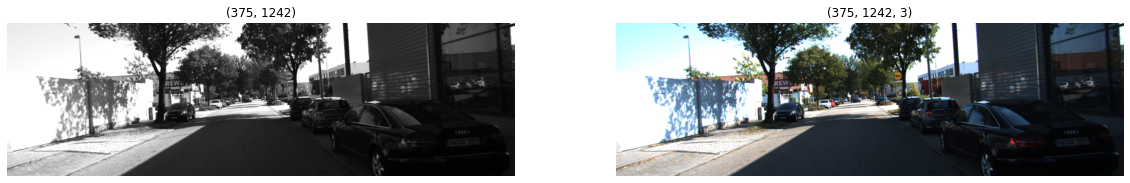

In [55]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
imshow(dataset.get_cam0(0), cmap='gray');
plt.subplot(1,2,2)
imshow(dataset.get_cam2(0));

In [56]:
vidname =  f"cam2-{dataset.sequence}.mp4"

if not os.path.exists(vidname):
    videoWriter(dataset.cam2, vidname, fps=10)
else:
    print(f'>> {vidname} already exists, {os.path.getsize(vidname)/1e6:.1f} MB')

>> cam2-01.mp4 already exists, 12.5 MB


In [57]:
from ipywidgets import Video
Video.from_file(vidname)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\xbf\x01Dmdat\x00\x…

# Inertial Sensors

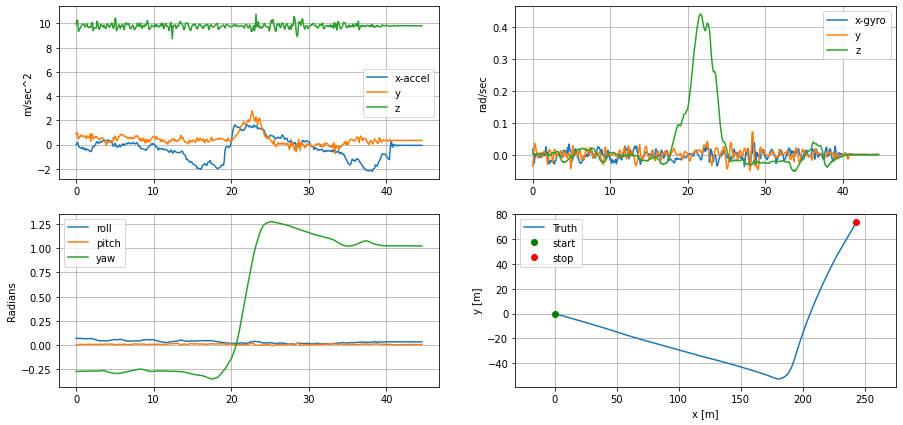

In [68]:
plotSensors(dataset.imu, dataset.oxts, dataset.timestamps)

## Video Odometry Setup

In [58]:
class VideoOdometry:
    """
    VideoOdometry
    """
    def __init__(self, K, yaw=0):
        """
        Args:
            K: camera matrix
            yaw: initial starting heading
        """
        self.K = K
        self.R_f = rotz(yaw)
        self.t_f = np.zeros((3,1))
        self.detector = self.featureDetection()
        self.preFeature = None
        self.preImage = None
        
    def featureTracking(self, img_1, img_2, p1):
        lk_params = dict( winSize  = (21,21),
                          maxLevel = 3,
                          criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))

        p2, st, err = cv2.calcOpticalFlowPyrLK(img_1, img_2, p1, None, **lk_params)
        st = st.reshape(st.shape[0])
        
        # find good ones
        p1 = p1[st==1]
        p2 = p2[st==1]

        return p1,p2
    
    def featureDetection(self):
        thresh = dict(threshold=25, nonmaxSuppression=True);
        fast = cv2.FastFeatureDetector_create(**thresh)
        return fast
    
    def loop(self, curImage, MIN_NUM_FEAT=1500):
        if self.preImage is None:
            self.preImage = curImage.copy()
            
        if (self.preFeature is None) or (len(self.preFeature) < MIN_NUM_FEAT):
            feature    = self.detector.detect(self.preImage)
            self.preFeature = np.array([e.pt for e in feature], dtype='float32')
            
        fc = self.K[0,0]
        pp = (self.K[0,2], self.K[1,2]) # (x,y)

        kp1 = self.detector.detect(curImage);
        self.preFeature, curFeature = self.featureTracking(self.preImage, curImage, self.preFeature)
        E, mask = cv2.findEssentialMat(curFeature, self.preFeature, fc, pp, cv2.RANSAC,0.999,1.0)
        _, R, t, mask = cv2.recoverPose(E, curFeature, self.preFeature, focal=fc, pp = pp)

        absolute_scale = 1.0
            
        if absolute_scale > 0.1:
            # FIXME: y-axis down ... subtract looks better?
            self.t_f = self.t_f - absolute_scale*self.R_f.dot(t)
            self.R_f = R.dot(self.R_f)
        else:
            print("crap ... bad scale:", absolute_scale)

        self.preImage = curImage
        self.preFeature = curFeature
        
        return self.R_f, self.t_f

# Run

In [62]:
def run(images, yaw, subset=None):
    #initialization
    if subset is None:
        MAX_FRAME = len(images)
    else:
        MAX_FRAME = subset

    ret_pos = []
    
    K = dataset.calib.K_cam2
    vo = VideoOdometry(K, yaw)
    
    for numFrame in tqdm(range(0, MAX_FRAME)):
        curImage = images[numFrame]
        R, t = vo.loop(curImage)
        ret_pos.append((t[0], t[2]))

    return ret_pos


imgs = [x for x in dataset.cam0]
# imgs = [cv2.resize(x,dsize=(x.shape[1]//3, x.shape[0]//3)) for x in dataset.cam0]

yaw = dataset.oxts[0].packet.yaw
print(f"Starting at Yaw {yaw * rad2deg:.1f} deg")
print(f"Found {len(imgs)} images")

pts = run(imgs, yaw, subset=None)

Starting at Yaw -15.5 deg
Found 447 images


100%|█████████████████████████████████████████| 447/447 [00:28<00:00, 15.94it/s]


In [63]:
# get the ground truth from GPS
x = []
y = []

# use the first point as the origin/start
slat = dataset.oxts[0].packet.lat
slon = dataset.oxts[0].packet.lon

for d in dataset.oxts:
    a = d.packet.lat
    b = d.packet.lon
    xx,yy = ll2xy(a,b,slat,slon)
    x.append(xx)
    y.append(yy)

tx = np.array(x)
ty = np.array(y)
    
# setup VO results
vox = np.array([x[0] for x in pts]).ravel()
voy = np.array([x[1] for x in pts]).ravel()

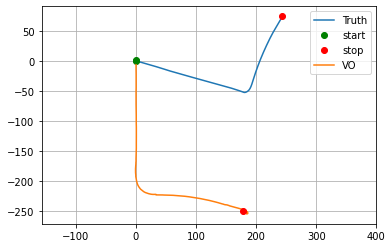

In [69]:
plt.plot(tx,ty,label="Truth")
plt.plot(tx[0],ty[0],"go", label="start")
plt.plot(tx[-1],ty[-1],"ro", label="stop")
plt.plot(vox,voy,label="VO")
plt.plot(vox[0],voy[0],"go")
plt.plot(vox[-1],voy[-1],"ro")
plt.legend()
plt.axis("equal")
plt.grid(True);